In [1]:
%pylab inline  

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.interpolate import CubicSpline
from patsy import dmatrix
import seaborn as sns
from ipywidgets import interact, IntSlider, FloatSlider
from csaps import csaps

# Simple Model

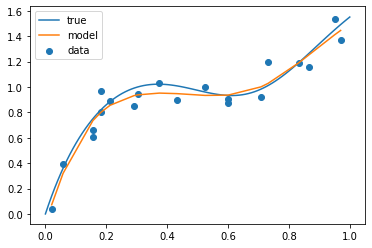

In [3]:
random_seed = 42
seed(random_seed)
f_true = lambda x: log(1+sin(2*pi*x)-cos(pi*x)+exp(x))
m = 20
X = random.uniform(0, 1, m)
X.sort()
Y = f_true(X) + random.normal(0, 0.1, m)
basis = dmatrix("bs(X, knots=(0.3, 0.7), degree=3)", {"x": X})
coefs = lstsq(basis, Y, rcond=None)[0]
x_grid = linspace(0, 1, 100)
plot(x_grid, f_true(x_grid), label="true")
scatter(X, Y, label="data")
plot(X, basis.dot(coefs), label="model")
legend()

# Bootstrap 

## Classic Bootstrap

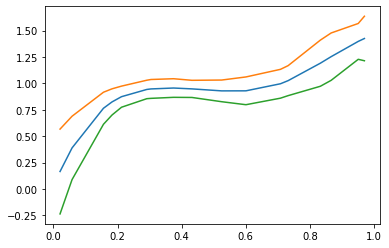

In [4]:
seed(random_seed)
Y_bootstrap_pred = []
W_bootstrap = []
for i in range(50):
    idx =  choice(m, m)
    idx.sort()
    Xs, Ys = X[idx], Y[idx]
    basis = dmatrix("bs(Xs, knots=(0.3, 0.7), degree=3)", {"x": Xs})
    coefs = lstsq(basis, Ys, rcond=None)[0]
    basis = dmatrix("bs(X, knots=(0.3, 0.7), degree=3)", {"x": X})
    preds = basis.dot(coefs)
    Y_bootstrap_pred.append(preds)
    W_bootstrap.append(coefs)
    #plot(X, preds)
Y_bootstrap_pred = vstack(Y_bootstrap_pred)
W_bootstrap = vstack(W_bootstrap)
stds_pointwise = std(Y_bootstrap_pred, axis=0)
mean_pred = Y_bootstrap_pred.mean(axis=0)
plot(X, mean_pred)
plot(X, mean_pred + 2*stds_pointwise)
plot(X, mean_pred - 2*stds_pointwise)

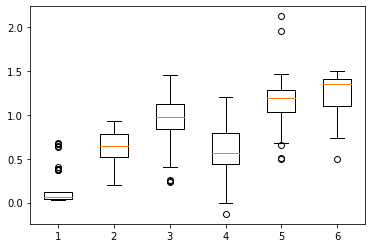

In [5]:
boxplot(W_bootstrap)
show()

# Sasha Bootstrap

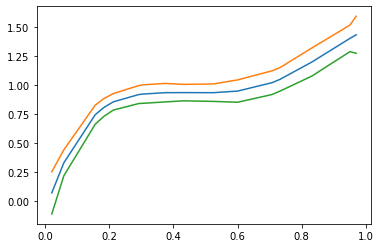

In [6]:
k = 20
seed(random_seed)
original_basis = dmatrix("bs(X, knots=(0.3, 0.7), degree=3)", {"x": X})
original_coefs = lstsq(basis, Y, rcond=None)[0]
sasha_coefs = []
sasha_predictions = []

for i in range(50):
    new_points = random.uniform(0, 1, k)
    new_basis = dmatrix("bs(X, knots=(0.3, 0.7), degree=3)", {"x": new_points})
    new_answers = new_basis.dot(original_coefs) + random.normal(0, 0.1, k) 
    new_coefs = lstsq(new_basis, new_answers, rcond=None)[0]
    new_predictions = original_basis.dot(new_coefs)
    sasha_coefs.append(new_coefs)
    sasha_predictions.append(new_predictions)

sasha_coefs = vstack(sasha_coefs)
sasha_predictions = vstack(sasha_predictions)
stds_pointwise = std(sasha_predictions, axis=0)
mean_pred = sasha_predictions.mean(axis=0)
plot(X, mean_pred)
plot(X, mean_pred + 2*stds_pointwise)
plot(X, mean_pred - 2*stds_pointwise)

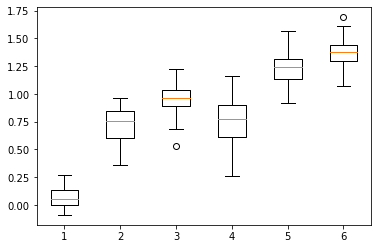

In [7]:
boxplot(sasha_coefs)
show()

In [9]:
def plot_soln(m, k, bootstrap_iters, random_seed, sigma):
    knots="(0.3, 0.7)"
    seed(random_seed)
    f_true = lambda x: log(1+sin(4*pi*x)-cos(pi*x)+exp(x))
    X = random.uniform(0, 1, m)
    X.sort()
    Y = f_true(X) + random.normal(0, sigma, m)
    original_basis = dmatrix("bs(x, knots=%s, degree=3)"%knots, {"x": X})
    original_coefs = lstsq(original_basis, Y, rcond=None)[0]
    
    x_grid = linspace(0, 1, 300)
    optimal_basis = dmatrix("bs(x, knots=%s, degree=3)"%knots, {"x": x_grid})
    optimal_coefs = lstsq(optimal_basis, f_true(x_grid), rcond=None)[0]
    
    sasha_coefs = []
    sasha_predictions = []

    for i in range(bootstrap_iters):
        new_points = random.uniform(0, 1, k)
        new_basis = dmatrix("bs(x, knots=%s, degree=3)"%knots, {"x": new_points})
        new_answers = new_basis.dot(original_coefs) + random.normal(0, sigma, k) 
        new_coefs = lstsq(new_basis, new_answers, rcond=None)[0]
        new_predictions = original_basis.dot(new_coefs)
        sasha_coefs.append(new_coefs)
        sasha_predictions.append(new_predictions)

    sasha_coefs = vstack(sasha_coefs)
    sasha_predictions = vstack(sasha_predictions)

    bootstrap_coefs = []
    bootstrap_predictions = []
    
    for i in range(bootstrap_iters):
        idx =  choice(m, m)
        idx.sort()
        Xs, Ys = X[idx], Y[idx]
        new_basis = dmatrix("bs(Xs, knots=%s, degree=3)"%knots, {"Xs": Xs})
        new_coefs = lstsq(new_basis, Ys, rcond=None)[0]
        new_predictions = original_basis.dot(new_coefs)
        bootstrap_predictions.append(new_predictions)
        bootstrap_coefs.append(new_coefs)
        
    bootstrap_predictions = vstack(bootstrap_predictions)
    bootstrap_coefs = vstack(bootstrap_coefs)
        
    fig = figure(figsize=(15, 10))
    grid = plt.GridSpec(2, 2, wspace=0.15, hspace=0.15)
    
    coefs_plot_1 = fig.add_subplot(grid[0, 0])
    coefs_plot_1.boxplot(sasha_coefs)
    coefs_plot_1.scatter([1, 2, 3, 4, 5, 6], optimal_coefs)
    coefs_plot_1.set_title("Sasha")
    
    coefs_plot_2 = fig.add_subplot(grid[0, 1])
    coefs_plot_2.boxplot(bootstrap_coefs)
    coefs_plot_2.scatter([1, 2, 3, 4, 5, 6], optimal_coefs)
    coefs_plot_2.set_title("Bootstrap")
    
    pred_plot_1 = fig.add_subplot(grid[1, 0])
    pred_plot_1.plot(x_grid, f_true(x_grid), label="true")
    pred_plot_1.scatter(X, Y, label="data")
    mean_pred = sasha_predictions.mean(axis=0)
    pred_plot_1.plot(X, mean_pred, label="prediction")
    stds_pointwise = std(sasha_predictions, axis=0)
    pred_plot_1.plot(X, mean_pred + 2*stds_pointwise, '--')
    pred_plot_1.plot(X, mean_pred - 2*stds_pointwise, '--')
    pred_plot_1.set_title("Sasha")
    pred_plot_1.legend()
    
    pred_plot_2 = fig.add_subplot(grid[1, 1])
    pred_plot_2.plot(x_grid, f_true(x_grid), label="true")
    pred_plot_2.scatter(X, Y, label="data")
    mean_pred = bootstrap_predictions.mean(axis=0)
    pred_plot_2.plot(X, mean_pred, label="prediction")
    stds_pointwise = std(bootstrap_predictions, axis=0)
    pred_plot_2.plot(X, mean_pred + 2*stds_pointwise, '--')
    pred_plot_2.plot(X, mean_pred - 2*stds_pointwise, '--')
    pred_plot_2.set_title("Bootstrap")
    pred_plot_2.legend()
    
interact(plot_soln, random_seed=IntSlider(min=1,max=50,value=42, description='random seed$'),
         m=IntSlider(min=3,max=100,value=20, description='m, number of points'),
         k=IntSlider(min=3,max=600,value=100, description='k, Sasha points'),
         bootstrap_iters=IntSlider(min=3,max=100,value=10, description='Bootstrap iterations'),
         sigma=FloatSlider(min=0,max=4,step=0.2,value=0.1,description='$\sigma$, noise level'));

interactive(children=(IntSlider(value=20, description='m, number of points', min=3), IntSlider(value=100, desc…

In [12]:
def f(x):
    return x+10
interact(f, x=10)

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

<function __main__.f(x)>